Chatbot with Tools such as Arxiv and Wikipedia and Google Search

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [4]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [5]:
arxiv.invoke("What is the latest research on LangChain?")

'Published: 2025-04-03\nTitle: A Review of Prototyping in XR: Linking Extended Reality to Digital Fabrication\nAuthors: Bixun Chen, Shaun Macdonald, Moataz Attallah, Paul Chapman, Rami Ghannam\nSummary: Extended Reality (XR) has expanded the horizons of entertainment and social\nlife and shows great potential in the manufacturing industry. Prototyping in XR\ncan help designers make initial proposals and iterations at low cost before\nmanufacturers and investors decide whether to invest in research, dev'

In [6]:
api_wrapper_wikipedia=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wikipedia)
wiki.name

'wikipedia'

In [7]:
wiki.invoke("What is the capital of France?")

'Page: Closed-ended question\nSummary: A closed-ended question is any question for which a researcher provides research participants with options from which to choose a response. Closed-ended questions are sometimes phrased as a statement that requires a response.\nA closed-ended question contrasts with an open-ended question, which cannot easily be answered with specific information.'

In [10]:
from dotenv import load_dotenv
load_dotenv()
import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

from langchain_community.tools import TavilySearchResults
tavily=TavilySearchResults(max_results=2)
tavily.invoke("What is the latest victory for team india as of 25th  OCT 2025?")




[{'title': '“Trophy was nowhere to be found,” Tilak Varma spills ...',
  'url': 'https://circleofcricket.com/category/Latest_news/100214/trophy-was-nowhere-to-be-found-tilak-varma-spills-beans-on-indias-stand-off-with-mohsin-naqvi-after-asia-cup-final-win',
  'content': "The arch-rivals faced each other thrice in the Asia Cup 2025 and India emerged victorious on all occasions. Tilak Varma starred with the bat in the title clash, returning with an unbeaten knock of 69 from 53 balls to pave the way for India’s five-wicket win.\n\nThanks to Tilak’s innings, India chases down the target of 147 with two deliveries to spare and clinched the continental showpiece for the record-extending ninth time. [...] Circle Of Cricket\nCircle Of Cricket\n\n## “Trophy was nowhere to be found,” Tilak Varma spills beans on India's stand-off with Mohsin Naqvi after Asia Cup final win\n\n## Team India had refused to collect the Asia Cup trophy from ACC and PCB chief Mohsin Naqvi.\n\nBy Salman Anjum - 25 Oct, 

In [11]:
##combine all the tools in the list

tools=[arxiv,wiki,tavily]

In [13]:
##Initialise the LLM
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model="gpt-4o-mini")
llm_with_tools=llm.bind_tools(tools)

In [16]:
from pprint import pprint
from langchain_core.messages import AIMessage,HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the latest victory for team india as of 25th  OCT 2025?")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'latest victory for team india as of October 25 2025'},
  'id': 'call_pKPxXKBTxKJ43Yn0XPz43jgQ',
  'type': 'tool_call'}]

In [17]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

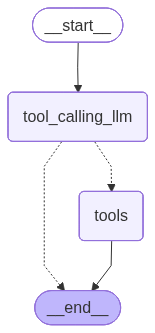

In [19]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

##Node Definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


graph=StateGraph(State)

#Add nodes
graph.add_node("tool_calling_llm",tool_calling_llm)
graph.add_node("tools",ToolNode(tools))
#Add edges
graph.add_edge(START,"tool_calling_llm")
graph.add_conditional_edges(
    "tool_calling_llm",
    #if the latest message (result) from assistant is a tool call ->tool condition routes to tool
    # If the latest message (result) from assistant is not a tool call->tool_condition routes to END
        tools_condition
)

graph.add_edge("tools",END)

graph_compile=graph.compile()

display(Image(graph_compile.get_graph().draw_mermaid_png()))


In [20]:
messages=graph_compile.invoke({"messages":HumanMessage(content="What is attention is all you need paper?")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is attention is all you need paper?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_rYdnMSy3PNFq5JBORnu7VFjM)
 Call ID: call_rYdnMSy3PNFq5JBORnu7VFjM
  Args:
    query: Attention is All You Need
================================= Tool Message =================================
Name: wikipedia

Page: Attention Is All You Need
Summary: "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al. It is considered a foundational paper in modern artificial intelligence, and a main contributor to the AI boom, as the transformer approach has become the main architecture of a wi


In [21]:
messages=graph_compile.invoke({"messages":HumanMessage(content="Top 10 recent AI news?")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Top 10 recent AI news?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_kJg4Uw7DdKiL6cjZcJQW7pB8)
 Call ID: call_kJg4Uw7DdKiL6cjZcJQW7pB8
  Args:
    query: recent AI news
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News | Latest AI News, Analysis & Events", "url": "https://www.artificialintelligence-news.com/", "content": "How AI is changing the way we travel · October 7, 2025 ; Spot AI introduces the world's first universal AI agent builder for security cameras · April 10, 2025", "score": 0.7946564}, {"title": "The 2025 AI Index Report | Stanford HAI", "url": "https://hai.stanford.edu/ai-index/2025-ai-index-report", "content": "In 2024, U.S. federal agencies introduced 59 AI-related regulations—more than double the number in 2023—and issued 